In [1]:
# Importing Dependencies
import numpy as np
import gym
from gym.envs.box2d.car_racing import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from statistics import mean
from pyglet.window import key
import time
from tqdm import tqdm 
import os
from keras.utils import normalize

Using TensorFlow backend.


In [2]:
# Function for generating data by playing
def start_playing(samples):
    a = np.array( [0.0, 0.0, 0.0] )
    def key_press(k, mod):
        global restart
        if k==0xff0d: restart = True
        if k==key.LEFT:  a[0] = -1.0
        if k==key.RIGHT: a[0] = +1.0
        if k==key.UP:    a[1] = +1.0
        if k==key.DOWN:  a[2] = +0.8   
    def key_release(k, mod):
        if k==key.LEFT  and a[0]==-1.0: a[0] = 0
        if k==key.RIGHT and a[0]==+1.0: a[0] = 0
        if k==key.UP:    a[1] = 0
        if k==key.DOWN:  a[2] = 0
    
    env = CarRacing()
    env.render()
    env.viewer.window.on_key_press = key_press
    env.viewer.window.on_key_release = key_release
    collected = {'l':0,'r':0,'s':0,'b':0} 
    X = []
    y = np.array([0.,1.,0.])
    game = 0
    while True:
        prev_observation = env.reset()        
        restart = False
        while True:
            action = a
            observation, reward, done, info = env.step(action)
            X.append(prev_observation)
            y = np.vstack((y, action))
            prev_observation=observation
            if np.array_equal(action, np.array([-1,0,0])) and collected['l']<samples['l']:
                collected['l'] += 1
            elif np.array_equal(action, np.array([1,0,0])) and collected['r']<samples['r']:
                collected['r'] += 1
            elif np.array_equal(action, np.array([0,1,0])) and collected['s']<samples['s']:
                collected['s'] += 1
            elif np.array_equal(action, np.array([0,0,0.8])) and collected['b']<samples['b']:
                collected['b'] += 1    
            env.render()
            if done or restart: break
        time.sleep(2)
        if collected['l']>=samples['l'] and collected['r']>=samples['r'] and collected['s']>=samples['s'] and collected['b']>=samples['b']:
            break
        game+=1
        if game%10 == 0:
            np.save('balanced_train_X.npy', X)
            np.save('balanced_train_y.npy', y)
    X = np.array(X)        
    np.save('balanced_train_X.npy', X)
    np.save('balanced_train_y.npy', y)    
    env.close()
    return X, y

In [3]:
# Playing the to create data
samples = {'l':2000, 'r':2000, 's':2000, 'b':2000}
X, y=start_playing(samples)

Track generation: 1208..1514 -> 306-tiles track
Track generation: 1084..1359 -> 275-tiles track
Track generation: 1037..1309 -> 272-tiles track
Track generation: 1040..1304 -> 264-tiles track
Track generation: 1095..1373 -> 278-tiles track
Track generation: 1105..1386 -> 281-tiles track
Track generation: 1105..1389 -> 284-tiles track
Track generation: 1118..1402 -> 284-tiles track
Track generation: 1220..1535 -> 315-tiles track
Track generation: 1153..1453 -> 300-tiles track
Track generation: 1278..1602 -> 324-tiles track
Track generation: 1140..1429 -> 289-tiles track
Track generation: 1221..1537 -> 316-tiles track
Track generation: 1144..1434 -> 290-tiles track
Track generation: 1119..1411 -> 292-tiles track
Track generation: 1132..1419 -> 287-tiles track
Track generation: 1187..1488 -> 301-tiles track
Track generation: 1012..1269 -> 257-tiles track
Track generation: 1104..1384 -> 280-tiles track
Track generation: 998..1261 -> 263-tiles track
Track generation: 1203..1517 -> 314-tiles

In [2]:
# Loading the data
X = np.load('X_balanced_final.npy')
y = np.load('y_balanced_final.npy')
X = X.reshape(-1,96,96,3)
y = y.reshape(-1,4)
print(X.shape)
print(y.shape)

(8001, 96, 96, 3)
(8001, 4)


In [73]:
new_X = []
new_X.append(X[0])
new_y = np.array([0,0,1,0])

moves={'l':0, 'r':0, 's':0, 'b':0}


for ix, iy in tqdm(zip(X, y)):
    if np.array_equal(iy, left) and moves['l']<500:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy))
        moves['l'] += 1
    elif np.array_equal(iy, right) and moves['r']<200:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy))
        moves['r'] += 1
    elif np.array_equal(iy, straight) and moves['s']<1000:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy))
        moves['s'] += 1
    elif np.array_equal(iy, stop) and moves['b']<400:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy)) 
        moves['b'] += 1

X = np.array(new_X).reshape(-1,96,96,3)
y = new_y.reshape(-1,4)
print(X.shape)
print(y.shape)     


0it [00:00, ?it/s]
6150it [00:00, 61444.10it/s]
8001it [00:00, 62450.69it/s]

(3401, 96, 96, 3)
(3401, 4)


In [4]:
# Variation in generated data
left=np.array([1,0,0,0])
right=np.array([0,1,0,0])
straight=np.array([0,0,1,0])
stop=np.array([0,0,0,1])
l=0
r=0
s=0
b=0

for key in y:
    if np.array_equal(key, left):
        l+=1
    elif np.array_equal(key, right):
        r+=1
    elif np.array_equal(key, straight):
        s+=1
    elif np.array_equal(key, stop):
        b+=1
        
print(l,r,s,b) 

2000 2000 2001 2000


In [82]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (96,96,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

In [83]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy")

In [84]:
model.fit(X, y, epochs=2, validation_split=0.2, batch_size=128, verbose=1, shuffle=True)

Train on 2720 samples, validate on 681 samples
Epoch 1/2
2720/2720 [==============================] - ETA: 42s - loss: 2.32 - ETA: 20s - loss: 2.08 - ETA: 13s - loss: 1.82 - ETA: 9s - loss: 1.6838 - ETA: 7s - loss: 1.534 - ETA: 6s - loss: 1.408 - ETA: 5s - loss: 1.302 - ETA: 4s - loss: 1.252 - ETA: 3s - loss: 1.178 - ETA: 3s - loss: 1.106 - ETA: 2s - loss: 1.032 - ETA: 2s - loss: 0.976 - ETA: 1s - loss: 0.941 - ETA: 1s - loss: 0.885 - ETA: 1s - loss: 0.844 - ETA: 0s - loss: 0.812 - ETA: 0s - loss: 0.774 - ETA: 0s - loss: 0.757 - ETA: 0s - loss: 0.725 - ETA: 0s - loss: 0.710 - ETA: 0s - loss: 0.685 - 4s 1ms/step - loss: 0.6838 - val_loss: 0.1974
Epoch 2/2
2720/2720 [==============================] - ETA: 1s - loss: 0.223 - ETA: 1s - loss: 0.205 - ETA: 1s - loss: 0.201 - ETA: 1s - loss: 0.199 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.197 - ETA: 0s - loss: 0.197 - ETA: 0s - loss: 0.204 - ETA: 0s - loss: 0.200 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.187 - ETA: 0s - loss: 0.192 - ETA:

In [2]:
# Saving the Model
model.save('Models/first_modelv2_4out_turn')

NameError: name 'model' is not defined

In [2]:
# Loading the Model
from keras.models import load_model
model = load_model('Models/first_modelv1_35_1_02_2_5')

In [ ]:
#scores = []
#choices = []
env = CarRacing()
for each_game in range(5):
    #score = 0
    #game_memory = []
    prev_obs = env.reset()
    for i in range(1000):  
        env.render()
        out = model.predict(prev_obs.reshape(-1,96,96,3))[0]
             
        turn = out[1]*0.7 if out[1]>out[0] else -out[0]*0.8
        turn = np.append(turn, out[2]*5)
        turn = np.append(turn, out[3]*0.8)
        print(turn)
        new_observation, reward, done, info = env.step(turn)
        prev_obs = new_observation
        #game_memory.append([new_observation, action])
        #score+=reward
        if done: 
            break
    #scores.append(score)
    #print('Episode {} Score: {}'.format(each_game+1,score))
    env.close()
#print('Average Score:',sum(scores)/len(scores))

Track generation: 1160..1454 -> 294-tiles track
[-2.31750118e-07  1.65851640e-12  1.32545626e-14]
[0.16048394 0.00061792 0.20036299]
[3.23389640e-01 7.03134401e-05 6.80346310e-02]
[0.41678958 0.00059495 0.09854006]
[0.4041315  0.00071476 0.0917123 ]
[0.30005449 0.00087203 0.08508959]
[0.262712   0.00170551 0.14666477]
[0.16397978 0.00429097 0.22905452]
[-0.22454638  0.00531973  0.19349003]
[-0.33447566  0.00836292  0.17762656]
[-0.38611217  0.01603623  0.16289121]
[-0.37579458  0.02279976  0.16617582]
[-0.38652928  0.03442198  0.13480202]
[-0.4165617   0.04767362  0.09066027]
[-0.36421518  0.08502913  0.09715938]
[-0.33898649  0.3397331   0.12364665]
[-0.33922563  0.38749885  0.12740195]
[-0.34556673  0.36270987  0.11540821]
[-0.32609658  0.41119434  0.10620526]
[-0.33764617  0.41254841  0.09108338]
[-0.31650574  0.42499967  0.08398445]
[-0.27446129  0.49205225  0.08671986]
[-0.22519453  0.61967123  0.09637696]
[-0.21328609  0.74724041  0.08066264]
[-0.22683322  0.80574334  0.07951815]

[0.22561112 1.20439291 0.08299671]
[0.21309039 0.97190991 0.07722474]
[0.21955947 0.86479299 0.07155139]
[0.17829804 1.33379966 0.06100003]
[0.14404978 1.42245546 0.0557188 ]
[-0.12447829  1.50654435  0.05048231]
[-0.20720024  1.3659583   0.04308071]
[-0.25463703  1.21292271  0.0408232 ]
[-0.31967444  1.06460907  0.04084453]
[-0.27728617  1.22280464  0.04836414]
[-0.20648296  1.54932335  0.04491929]
[-0.14858977  1.74425364  0.05266516]
[0.13677003 1.70349732 0.05669095]
[0.19825026 1.22228205 0.0605934 ]
[0.2617229  0.91371    0.05856658]
[0.27096212 0.72236829 0.06531079]
[0.25156484 0.71250021 0.06656376]
[0.22287737 0.77751428 0.06500856]
[0.18215875 0.84950954 0.06581749]
[0.13680249 1.28346011 0.06674092]
[-0.14181279  1.31578997  0.06029416]
[-0.21770618  1.06300704  0.05639431]
[-0.19326699  1.22258194  0.06722676]
[-0.31654305  0.73792294  0.05569204]
[-0.23488121  0.87213106  0.06088161]
[-0.17409976  1.01850793  0.07737605]
[0.13708152 1.00246496 0.07655832]
[0.21803146 0.81

[-0.11961375  0.68246983  0.06143662]
[0.13476081 0.56504887 0.06567777]
[0.20648009 0.39594088 0.05950061]
[0.20510074 0.60390264 0.06229906]
[0.19420626 0.41421395 0.05664669]
[0.19755012 0.31556539 0.04622312]
[0.16472404 0.29655045 0.04498279]
[0.11958813 0.27967015 0.04044468]
[-0.15969808  0.24193261  0.03694163]
[-0.17748933  0.26970677  0.03976528]
[0.12959995 0.4176325  0.05816837]
[0.16543435 0.2990884  0.05094681]
[0.16682931 0.23286104 0.04490775]
[-0.18427508  0.2633022   0.05200691]
[-0.22036104  0.29432219  0.06023861]
[0.1786743  0.34123003 0.06449309]
[0.20101357 0.32609876 0.06886029]
[0.19706682 0.39580468 0.07057166]
[0.17180071 0.51741347 0.07899665]
[0.16579617 0.72379433 0.08804007]
[0.15550123 0.85402399 0.09355447]
[-0.19207127  0.8692763   0.09462957]
[-0.26352696  0.83561935  0.09174926]
[-0.27983146  0.767214    0.08672646]
[-0.2897331   0.74677974  0.08698775]
[-0.1911245   0.89063071  0.10159305]
[0.16940704 0.88249169 0.09664901]
[0.21012666 0.83384946 0.

[-0.1085835   0.47354769  0.05866448]
[-0.12824377  0.58025029  0.05388446]
[0.08428505 0.89505814 0.07167746]
[0.114827   0.60448639 0.07315617]
[0.12206738 0.4995174  0.06263143]
[-0.15919497  0.56494545  0.05598192]
[-0.20549278  0.75647563  0.05843232]
[-0.12302949  1.24885872  0.07507438]
[-0.18566875  0.72797395  0.05893991]
[0.16165377 0.75913884 0.06905191]
[0.25637864 0.5892086  0.05694176]
[0.24464733 0.87650158 0.07820802]
[0.25038981 0.6155761  0.06892793]
[0.25632081 0.59485801 0.05994255]
[0.24736318 0.64900532 0.06296432]
[0.19973995 0.78802489 0.05764471]
[0.19141086 1.15152821 0.05951374]
[0.14184246 1.42758861 0.06335194]
[-0.14032929  1.50672495  0.05796621]
[-0.17135764  1.59138277  0.06189758]
[-0.17779393  1.44651324  0.0654546 ]
[-0.19043717  1.42910182  0.07222425]
[-0.16675887  1.4225404   0.07267335]
[0.15195417 1.4236261  0.07570783]
[0.24935703 1.00458831 0.07015306]
[0.35675203 0.71579471 0.07219564]
[0.36982284 0.67000121 0.071316  ]
[0.3566123  0.69501109

[-0.47997561  0.12121514  0.11578163]
[-0.47976451  0.12630982  0.1386222 ]
[-0.52762957  0.11951284  0.12805836]
[-0.6151793   0.08218049  0.0976765 ]
[-0.60642967  0.10594795  0.08553581]
[-0.59915862  0.12417312  0.08278048]
[-0.55165606  0.17053869  0.0909969 ]
[-0.54124532  0.15801048  0.07133519]
[-0.5371335   0.20598896  0.05992304]
[-0.56942363  0.18126838  0.04452327]
[-0.59826975  0.15004706  0.03726157]
[-0.57913489  0.15746513  0.04152319]
[-0.54828191  0.18668685  0.04328661]
[-0.57872648  0.19227084  0.03814169]
[-0.55816946  0.20092282  0.04169882]
[-0.55891604  0.23452381  0.04044606]
[-0.53996301  0.28085627  0.04071814]
[-0.53449321  0.31452384  0.03937467]
[-0.48605185  0.47498301  0.04243581]
[-0.37359364  0.82807288  0.05644609]
[-0.14762032  1.83555096  0.06712204]
[0.15011132 2.08328262 0.07162083]
[0.18243145 2.0365341  0.06681791]
[0.27611983 1.49006262 0.07382094]
[0.40633745 0.68912603 0.07384887]
[0.4966037  0.27350714 0.05910916]
[0.54847229 0.19815803 0.05

[-0.13371396  1.75197169  0.05674714]
[0.10419811 2.17409566 0.05314336]
[0.11736647 2.21146226 0.05466599]
[0.13584784 2.09200814 0.05493501]
[0.11579316 2.60584682 0.05436926]
[0.15674994 1.86975062 0.06501449]
[0.15710546 1.68983206 0.07085615]
[0.11975494 1.95571288 0.06788786]
[0.12930035 1.82606637 0.06401841]
[0.13029573 1.75267071 0.06617067]
[0.12920858 1.54352546 0.06894701]
[0.11938016 1.44809425 0.06616717]
[0.10497867 1.35947838 0.06117339]
[-0.13604313  1.26224041  0.05953904]
[-0.18310585  1.11625008  0.05655154]
[-0.15156854  1.46474972  0.06109976]
[-0.2328666   1.05644159  0.05184402]
[-0.20602283  1.14806615  0.05385082]
[-0.15412809  1.41500294  0.05774946]
[-0.12353944  1.52273178  0.05840002]
[0.13329792 1.39953509 0.0621269 ]
[0.17301901 1.20701276 0.06611934]
[0.17592194 1.37178063 0.07846911]
[0.19422376 0.99163987 0.08067153]
[0.19673498 0.94021395 0.07508298]
[0.16708729 1.02450192 0.06655126]
[0.13071008 1.20995797 0.06475698]
[-0.13363339  1.23606063  0.060

[-0.11042496  1.42722949  0.04893057]
[0.10534605 1.53595984 0.07140552]
[0.1399878  1.62240028 0.07062361]
[0.11400978 2.18325838 0.06203256]
[0.12357922 1.51630953 0.07306598]
[0.11703968 1.26914889 0.07410796]
[-0.13472078  0.87106153  0.07059714]
[-0.22699618  0.6017423   0.05520046]
[-0.21476958  0.78777492  0.06090861]
[-0.35390949  0.36561731  0.04097284]
[-0.34806159  0.3450292   0.04235423]
[-0.34337983  0.43477014  0.04629632]
[-0.2682199   0.60655788  0.05000132]
[-0.23738725  0.64540647  0.05680791]
[-0.21435041  0.71816593  0.06702678]
[-0.15029587  0.86754948  0.07616201]
[-0.13864162  0.9731634   0.06372023]
[0.13253927 1.05245322 0.06918551]
[0.18946916 1.00121342 0.07308646]
[0.15634899 1.60982519 0.07475001]
[0.14751787 1.20873824 0.07067279]
[-0.14684974  0.97663425  0.0707598 ]
[-0.20092564  0.8392068   0.05888048]
[-0.1812062   1.09453596  0.06812424]
[-0.2890146   0.6667494   0.04748216]
[-0.23464513  0.74458331  0.04880663]
[-0.27550232  0.76956064  0.04622288]
[

[0.18583943 0.71070023 0.06536931]
[0.17120655 0.60660407 0.05991691]
[0.13231729 0.39595604 0.06004224]
[-0.12341732  0.2996967   0.06529748]
[-0.13870398  0.31245215  0.06423659]
[-0.12561152  0.67393146  0.07554913]
[-0.18791611  0.43257643  0.09029593]
[-0.22128999  0.39597098  0.09885145]
[-0.22701356  0.4028653   0.09063523]
[-0.24193251  0.38193859  0.10084817]
[-0.26643496  0.34441128  0.10772636]
[-0.25734642  0.30981708  0.11990281]
[-0.26711659  0.27345762  0.12731698]
[-0.30261967  0.25311871  0.13413482]
[-0.39064596  0.2755999   0.12878395]
[-0.49484248  0.24273055  0.11395137]
[-0.62398787  0.15907064  0.07587738]
[-0.68783178  0.10514454  0.04662444]
[-0.71897202  0.06282907  0.0361439 ]
[-0.74926853  0.03016452  0.02589773]
[-0.77020864  0.01781328  0.01643204]
[-0.78541055  0.00461425  0.00971296]
[-0.7862493   0.00412558  0.00903806]
[-0.79004121  0.00403874  0.00675497]
[-0.78697567  0.00496901  0.00782619]
[-0.78238163  0.0074844   0.00790158]
[-0.7733829   0.00778

[-0.32731647  0.69099113  0.04934526]
[-0.30722907  0.78084454  0.04578786]
[-0.24488277  1.0509114   0.05311438]
[-0.16449618  1.26889378  0.06408495]
[0.11233252 1.2893787  0.06956246]
[0.16732435 1.15270168 0.07356822]
[0.18543133 0.89266241 0.0706971 ]
[0.19100685 1.09358452 0.07951814]
[0.16831635 0.92018679 0.08084168]
[0.17280413 0.80947302 0.07719914]
[0.14129877 0.94344139 0.06885706]
[-0.14055839  0.94947904  0.06133863]
[-0.1963187  0.8987049  0.0538456]
[-0.23853872  0.86419255  0.05208824]
[-0.2535306   0.91227777  0.05966709]
[-0.23434398  0.90742655  0.05877642]
[-0.15605797  1.10168785  0.07040511]
[0.12464441 1.13859899 0.0759416 ]
[0.19055013 0.91186076 0.07925845]
[0.2348762  0.7531707  0.08087445]
[0.22744552 0.76894879 0.07729004]
[0.19315535 0.85585691 0.08552711]
[0.17037555 0.86621419 0.07468193]
[0.14015691 0.95807083 0.06864132]
[-0.16513245  0.91416031  0.06318126]
[-0.25348346  0.73890582  0.05441961]
[-0.22592301  1.0559386   0.06517001]
[-0.35702775  0.586

[-0.54202538  0.06360179  0.01908753]
[-0.48450141  0.10571931  0.02524924]
[-0.42081366  0.14997468  0.03584046]
[-0.37271562  0.22486351  0.04288711]
[-0.28899837  0.27202064  0.05998513]
[-0.18354962  0.38716793  0.07047372]
[0.0758164  0.43764561 0.06038258]
[0.10127057 0.40666621 0.07733133]
[0.12810349 0.305287   0.08025675]
[0.14941751 0.24272896 0.07068313]
[0.17869998 0.29983785 0.09498294]
[0.14274122 0.17849008 0.0774446 ]
[0.11615527 0.20951407 0.08463003]
[0.12489795 0.23240745 0.09259737]
[0.13096953 0.26917325 0.09192383]
[-0.16945136  0.21162141  0.08381336]
[-0.24269958  0.19428952  0.09133787]
[-0.19125531  0.33627659  0.14429988]
[-0.27067907  0.1658161   0.14715251]
[-0.28015354  0.1441898   0.15729531]
[-0.38949258  0.10825684  0.11901824]
[-0.32828822  0.14680427  0.15592716]
[-0.33256319  0.1546249   0.16915965]
[-0.37221761  0.14329312  0.15018842]
[-0.3811748   0.15662141  0.16648613]
[-0.30460987  0.27716417  0.18040115]
[-0.26591649  0.31945199  0.13980801]
[

[-0.22776504  0.52078828  0.1172314 ]
[-0.21573169  0.55991076  0.10838921]
[-0.23023229  0.5240903   0.0966647 ]
[-0.24690077  0.4941877   0.09356675]
[-0.23939805  0.47450781  0.08807597]
[-0.28341253  0.47249939  0.08018116]
[-0.27148886  0.56986347  0.10116254]
[-0.24007633  0.60100079  0.09642192]
[-0.22625468  0.71287595  0.07632416]
[-0.21586065  0.65182045  0.0724527 ]
[-0.2587858   0.5296395   0.06947566]
[-0.24480417  0.58833718  0.06541545]
[-0.19437126  0.70172809  0.06581329]
[-0.1844789   0.70244439  0.06739314]
[-0.1803713   0.64034402  0.06878645]
[-0.1888329   0.59759773  0.06701775]
[-0.15295317  0.57694927  0.07648123]
[0.13398542 0.52857019 0.07509422]
[0.14315536 0.38484719 0.07109498]
[0.18131602 0.35183735 0.08475564]
[0.18286379 0.32462534 0.07524056]
[0.18330178 0.34379516 0.07585309]
[0.16809191 0.36437947 0.07429405]
[0.15395067 0.3810697  0.07068902]
[0.14055185 0.36139064 0.07019349]
[-0.19087504  0.33499081  0.0710574 ]
[-0.19909445  0.35098296  0.07122529

[0.39334391 0.71828812 0.06053308]
[0.48845794 0.2773235  0.05276649]
[0.53698534 0.12624016 0.04253909]
[0.54212748 0.07457305 0.0447497 ]
[0.53152956 0.07063086 0.04322644]
[0.50432842 0.08460763 0.05044351]
[0.49162691 0.09403155 0.05635686]
[0.43333502 0.16898097 0.05770422]
[0.34205641 0.38061179 0.06709287]
[0.24645211 0.72324097 0.05880578]
[0.1626987  1.07001811 0.06206005]
[0.11039182 1.5989913  0.05431123]
[-0.1100577   1.63253471  0.05220404]
[-0.15652071  1.36888653  0.05206708]
[-0.19432899  1.24037281  0.05136142]
[-0.24784172  1.09862439  0.05067056]
[-0.21748331  1.0459806   0.06049126]
[-0.18224905  1.10020027  0.06639628]
[-0.1412266   1.2176057   0.06716866]
[0.12885597 1.21422343 0.07282423]
[0.15653445 1.00933306 0.06878733]
[0.17417638 0.89036934 0.07537184]
[0.14432204 1.06798455 0.07473124]
[0.14170945 0.97323552 0.06910819]
[0.11975441 0.98004654 0.0660658 ]
[-0.17743021  0.89954697  0.05957661]
[-0.25391934  0.79425789  0.05104544]
[-0.19689841  1.162652    0.

[0.12915006 0.78500792 0.06770416]
[-0.14535383  0.64727515  0.06271443]
[-0.17398001  0.55121459  0.06292551]
[-0.11983428  0.89152135  0.06742262]
[-0.17725794  0.60386177  0.06352924]
[-0.1451967   0.62486622  0.06193864]
[0.13186088 0.57575654 0.06486931]
[0.14602273 0.54904941 0.05779588]
[0.15280367 0.51243726 0.06575156]
[0.15711689 0.5625686  0.06310756]
[0.13633329 0.53570528 0.07045779]
[-0.19469372  0.5059886   0.06747955]
[-0.19915726  0.4844746   0.06651413]
[-0.15844138  0.83634183  0.07981868]
[-0.26507142  0.47601789  0.07164732]
[-0.27350206  0.4413455   0.0726024 ]
[-0.25070102  0.45343813  0.07265767]
[-0.26685243  0.49901504  0.06916934]
[-0.22581954  0.56770198  0.07103653]
[-0.22674806  0.58818366  0.07173809]
[-0.20745225  0.65596104  0.06895694]
[-0.21347923  0.48205629  0.07174437]
[-0.20200551  0.59283115  0.0764809 ]
[-0.20813653  0.71040817  0.07461321]
[-0.20563667  0.78457229  0.072233  ]
[-0.20367665  0.84426999  0.0682126 ]
[-0.17250448  1.07137643  0.06

[0 0 0 1]


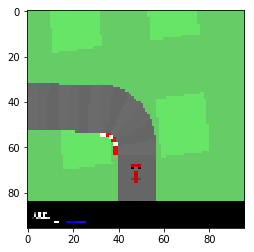

In [71]:
import matplotlib.pyplot as plt
i=30
plt.imshow(X[i])
print(y[i])
